In [1]:
import torch

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import os

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from torch.nn import Module
from torch.nn import TransformerEncoderLayer
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoderLayer
from torch.nn import TransformerDecoder
from torch.nn import LayerNorm
from torch.nn import BatchNorm1d
from torch.nn import Linear

from torch import optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn.functional import mse_loss

import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

In [7]:
df = pd.read_csv("./preprocessed-data/krwkzt.csv", index_col="Date")
df.head()

,Close
Date,
2004-01-02,0.115789
2004-01-05,0.114777
2004-01-06,0.115528
2004-01-07,0.114479
2004-01-08,0.115056


In [8]:
def get_date(x): 
    return pd.to_datetime(x).date()

In [9]:
df.index = df.index.map(lambda x: get_date(x))

In [10]:
df.index

Index([2004-01-02, 2004-01-05, 2004-01-06, 2004-01-07, 2004-01-08, 2004-01-09,
       2004-01-12, 2004-01-13, 2004-01-14, 2004-01-15,
       ...
       2023-10-22, 2023-10-23, 2023-10-24, 2023-10-25, 2023-10-26, 2023-10-27,
       2023-10-28, 2023-10-29, 2023-10-30, 2023-10-31],
      dtype='object', name='Date', length=5954)

In [11]:
def min_max_normalization(x, min, max):
    return (x - min) / (max - min)

In [12]:
def get_feat(x):
    return [min_max_normalization(x.year, 2004, 2023), min_max_normalization(x.month, 1, 12), min_max_normalization(x.day, 1, 31)]

In [13]:
def get_features(data, _from, _to):
    return [get_feat(x) for x in data.iloc[_from:_to].index]
    return data.iloc[_from:_to].index.map(lambda x: [get_date(x).year, get_date(x).month, get_date(x).day]).to_list()

In [14]:
def get_values(data, _from, _to):
    return data.iloc[_from:_to].Close.to_list()

In [15]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

# Initializing a Time Series Transformer configuration with 30 time steps for prediction
configuration = TimeSeriesTransformerConfig(context_length=96, 
                                            prediction_length=30,
                                            num_time_features=3
                                            # num_static_categorical_features=64,
                                            # num_static_real_features=64,
                                            )

# Randomly initializing a model (with random weights) from the configuration
model = TimeSeriesTransformerForPrediction(configuration).to(device)

# Accessing the model configuration
configuration = model.config

In [16]:
# refered: https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch3-preprocessing.html
def create_sequences(data, context_len, prediction_len):
    batch_data = []
    for i in tqdm(range(len(data)-context_len-prediction_len+1)):
        x = get_values(data, i, i+context_len)
        y = get_values(data, i+context_len, i+context_len+prediction_len)

        x_feat = get_features(data, i, i+context_len)
        y_feat = get_features(data, i+context_len, i+context_len+prediction_len)
        batch_data.append({
            "past_values": torch.Tensor(x).type(torch.FloatTensor),
            "future_values": torch.Tensor(y).type(torch.FloatTensor),
            "past_time_features": torch.Tensor(x_feat).type(torch.FloatTensor),
            "future_time_features": torch.Tensor(y_feat).type(torch.FloatTensor),
            "past_observed_mask": torch.Tensor(np.ones(context_len, dtype=bool)).type(torch.BoolTensor),
            "future_observed_mask": torch.Tensor(np.ones(context_len, dtype=bool)).type(torch.BoolTensor),
        })

    return batch_data

In [17]:
class CustomDataset(Dataset):
    def __init__(self, mode="train", context_len=96, prediction_len=12):
        df = pd.read_csv("./preprocessed-data/krwvnd.csv", index_col="Date")
        df.index = df.index.map(lambda x: get_date(x))
        df["Close"] = df["Close"].map(lambda x: float(x))
        df = df.div(df.iloc[0])

        train_size = int(len(df) * 0.8)

        if mode == "train":
            self.data = create_sequences(df[:train_size], context_len+max(configuration.lags_sequence), prediction_len)
        elif mode == "valid":
            self.data = create_sequences(df[train_size:], context_len+max(configuration.lags_sequence), prediction_len)
        # else:

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [18]:
EPOCH = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
MODEL_PATH = "./models-kzt"

In [19]:
dataset = CustomDataset(mode="train", context_len=96, prediction_len=30)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataset = CustomDataset(mode="valid", context_len=96, prediction_len=30)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 1064/1064 [00:00<00:00, 2235.60it/s]


In [20]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
sum(p.numel() for p in model.parameters())

136003

In [22]:
# Prepare loss history
hist_loss = np.zeros(EPOCH)
hist_loss_val = np.zeros(EPOCH)

# Record the best model
valid_loss_best = np.inf

for epoch in range(EPOCH):
    train_loss = 0
    valid_loss = 0
    model.train()
    with tqdm(total=len(train_loader), desc=f"[Epoch {epoch+1:3d}/{EPOCH}]") as pbar:
        for idx, batch in enumerate(train_loader):
            outputs = model(
                past_values=batch["past_values"].to(device),
                past_time_features=batch["past_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                # future_observed_mask=batch["future_observed_mask"],
            )
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()

            pbar.set_postfix({'train_loss': train_loss/(idx+1)})
            pbar.update(1)

        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_loader):
                outputs = model(
                    past_values=batch["past_values"].to(device),
                    past_time_features=batch["past_time_features"].to(device),
                    future_values=batch["future_values"].to(device),
                    future_time_features=batch["future_time_features"].to(device),
                    past_observed_mask=batch["past_observed_mask"].to(device),
                )
                loss = outputs.loss
                valid_loss += loss.detach().cpu().item()
                pbar.set_postfix({'valid_loss': valid_loss/(idx+1)})

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        pbar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss})

        hist_loss[epoch] = train_loss
        hist_loss_val[epoch] = valid_loss

        if valid_loss < valid_loss_best:
            valid_loss_best = valid_loss
            torch.save(model.state_dict(), os.path.join(MODEL_PATH, f"epoch-{epoch}"))
    

[Epoch 100/100]: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s, train_loss=-1.75, valid_loss=-1.73]


model exported to ./models-kzt with loss -1.939301


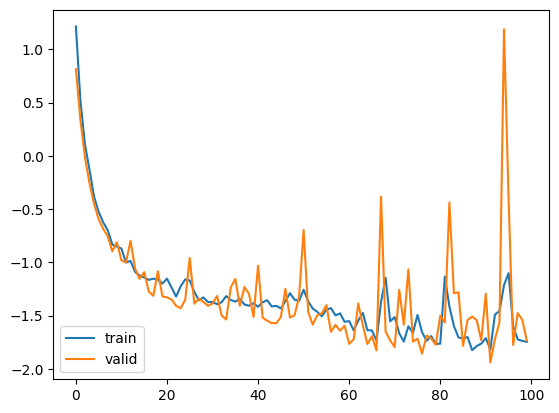

In [23]:
plt.plot(hist_loss, label='train')
plt.plot(hist_loss_val, label='valid')
plt.legend()
print(f"model exported to {MODEL_PATH} with loss {valid_loss_best:6f}")

In [28]:
df = pd.read_csv("./preprocessed-data/krwkzt.csv", index_col="Date")
df.index = df.index.map(lambda x: get_date(x))
df["Close"] = df["Close"].map(lambda x: float(x))
scale = df.iloc[0].values[0]
df = df.div(df.iloc[0])

In [24]:
def denormalize(x):
    return x * scale

In [27]:
model.eval()
with torch.no_grad():
    avg_mse = 0
    NUM_LOOP = 100
    with tqdm(total=NUM_LOOP) as pbar:
        for _ in range(NUM_LOOP):
            mse_valid = 0
            for idx, batch in enumerate(valid_loader):
                outputs = model.generate(
                    past_values=batch["past_values"][0].unsqueeze(0).to(device),
                    past_time_features=batch["past_time_features"][0].unsqueeze(0).to(device),
                    # future_values=batch["future_values"][0].unsqueeze(0).to(device),
                    future_time_features=batch["future_time_features"][0].unsqueeze(0).to(device),
                    past_observed_mask=batch["past_observed_mask"][0].unsqueeze(0).to(device),
                    # num_beams=1,
                )

                prediction = denormalize(outputs.sequences.mean(dim=1).to(device))
                ground_truth = denormalize(batch['future_values'][0].unsqueeze(0).to(device))

                mse_valid += mse_loss(prediction, ground_truth).cpu().item()
            
            avg_mse += mse_valid
            pbar.set_postfix({'Avg_MSE': avg_mse/(_+1)})
            pbar.update(1)

    print(f"MSE Loss: {avg_mse/(NUM_LOOP)}")

    # plt.plot(prediction.squeeze(0).detach().cpu().numpy(), color="orange")
    # plt.plot(ground_truth.squeeze(0).detach().cpu().numpy(), color="green")
    # plt.show()

  5%|▌         | 5/100 [00:12<03:57,  2.50s/it, Avg_MSE=0.000147]

In [29]:
df

,Close
Date,
2004-01-02,1.000000
2004-01-05,0.991265
2004-01-06,0.997749
2004-01-07,0.988689
2004-01-08,0.993674
...,...
2023-10-27,2.988768
2023-10-28,2.988659
2023-10-29,2.988659


In [30]:
df[-96-7:]

,Close
Date,
2023-07-21,2.992769
2023-07-22,2.990081
2023-07-23,2.990081
2023-07-24,3.005961
2023-07-25,3.016126
...,...
2023-10-27,2.988768
2023-10-28,2.988659
2023-10-29,2.988659


In [31]:
test_df = pd.read_csv("./krwkzt-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df["Close"] = test_df["Close"] / scale
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,3.008319
2023-11-02,3.017583
2023-11-03,3.042719
2023-11-04,3.042360
2023-11-05,3.042360


In [32]:
data = pd.concat([df[-96-7:], test_df])
data
# create_sequences(df[:train_size], context_len+max(configuration.lags_sequence), prediction_len)

,Close
Date,
2023-07-21,2.992769
2023-07-22,2.990081
2023-07-23,2.990081
2023-07-24,3.005961
2023-07-25,3.016126
...,...
2023-11-26,3.041276
2023-11-27,3.042015
2023-11-28,3.055723


In [33]:
inp = create_sequences(data, 96+max(configuration.lags_sequence), 30)

100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


In [101]:
model.load_state_dict(torch.load(f"{MODEL_PATH}/epoch-32"))

<All keys matched successfully>

In [102]:
model.eval()
with torch.no_grad():
    outputs = model.generate(
        past_values=inp[0]["past_values"].unsqueeze(0).to(device),
        past_time_features=inp[0]["past_time_features"].unsqueeze(0).to(device),
        # future_values=inp[0]["future_values"].unsqueeze(0).to(device),
        future_time_features=inp[0]["future_time_features"].unsqueeze(0).to(device),
        past_observed_mask=inp[0]["past_observed_mask"].unsqueeze(0).to(device),
        # num_beams=1,
    )
    # print(outputs.sequences.mean(dim=1).squeeze(0).cpu())
    prediction = denormalize(outputs.sequences.mean(dim=1).squeeze(0).cpu().numpy())
    print(prediction)

[0.3490258  0.3520236  0.3478734  0.35201102 0.35014856 0.34696764
 0.3479426  0.34919867 0.3468091  0.35259932 0.35049793 0.3462936
 0.34995866 0.34811363 0.35067692 0.34871182 0.34511542 0.34970045
 0.34730652 0.35347205 0.349125   0.3481722  0.35077325 0.35111147
 0.35350922 0.35056013 0.3475059  0.35081002 0.3521096  0.3515084 ]


In [103]:
ground_truth = denormalize(inp[0]['future_values'].numpy())
print(ground_truth)

[0.34832987 0.34940252 0.35231298 0.35227144 0.35227144 0.35701582
 0.3565124  0.35835826 0.3563158  0.35279942 0.35332152 0.35332152
 0.35301498 0.3552217  0.3554606  0.35736582 0.3561715  0.35613874
 0.35613874 0.35904092 0.35383996 0.3525469  0.3503616  0.35303703
 0.35208756 0.35214597 0.35223144 0.3538187  0.35591698 0.3541214 ]


In [104]:
mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))

tensor(3.2352e-05)

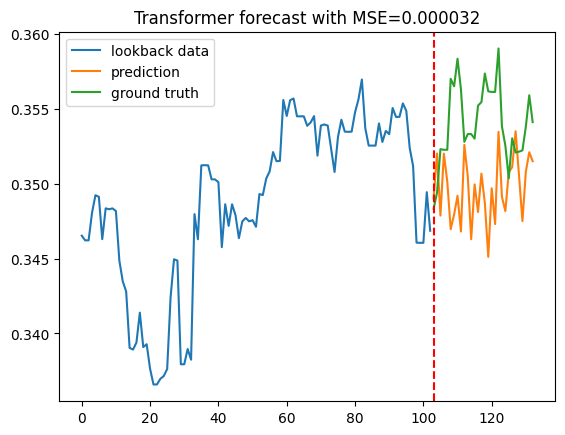

In [105]:
mse = mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))
denormalized_data = denormalize(df[-96-7:]["Close"].to_numpy())
num_lookback = denormalized_data.shape[0]

plt.plot(denormalized_data, label="lookback data")
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, prediction]), label='prediction')
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, ground_truth]), label='ground truth')
plt.title(f"Transformer forecast with MSE={mse:.6f}")
plt.axvline(x=denormalized_data.shape[0], c='r', linestyle='--')
plt.legend()
plt.show()

In [40]:
denormalized_data = denormalize(data["Close"].to_numpy())

array([0.34652936, 0.34621808, 0.34621808, 0.34805682, 0.34923384,
       0.34912917, 0.3462993 , 0.34835768, 0.34829774, 0.34835494,
       0.3481757 , 0.34486678, 0.34347802, 0.3428007 , 0.33903614,
       0.3389194 , 0.33938754, 0.3413872 , 0.33908686, 0.33927846,
       0.33762828, 0.3365877 , 0.3365879 , 0.33696312, 0.33714962,
       0.33762127, 0.34241486, 0.34495428, 0.34486935, 0.33793828,
       0.3379381 , 0.33895728, 0.33824635, 0.34797326, 0.3462925 ,
       0.35123047, 0.35124132, 0.35123047, 0.35029545, 0.35029328,
       0.35010892, 0.34576336, 0.3486311 , 0.34718627, 0.34862846,
       0.34790233, 0.3463634 , 0.34748933, 0.34771538, 0.34748793,
       0.34756935, 0.34712696, 0.34931308, 0.34924504, 0.3503521 ,
       0.35082465, 0.35211912, 0.35151026, 0.35152593, 0.35560095,
       0.35453057, 0.35558462, 0.35569817, 0.35450757, 0.35450774,
       0.35450622, 0.35387444, 0.35409632, 0.3545214 , 0.35187912,
       0.35389045, 0.35396388, 0.35388783, 0.35233793, 0.35078